In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import chain
import re
from glob import glob
!pip install sentence_transformers
from sentence_transformers import SentenceTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report , accuracy_score
from sklearn.model_selection import train_test_split
import statistics
from sklearn.preprocessing import MultiLabelBinarizer
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_validate
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 4.7 MB/s 
     |████████████████████████████████| 5.8 MB 41.6 MB/s 
     |████████████████████████████████| 1.3 MB 70.8 MB/s 
     |████████████████████████████████| 182 kB 78.5 MB/s 
     |████████████████████████████████| 7.6 MB 67.8 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=edd31a0bb1325e2b71d45b088619b36445b4a10daec65cd3c166ed5bf38d3ffc
  Stored in directory: /root/.cache/pip/wheels/5e/6f/8c/d88aec621f3f542d26fac0342bef5e693335d125f4e54aeffe
Successfully built sentence-transformers


##Read all the CSVS and initialize the embedding model

In [ ]:
csvs = []
authors=[]
for i , dfs in enumerate(glob('/content/drive/MyDrive/ML Assignment/Project/ML Phase 1 files/Corrected files/*.csv')):
    temp = dfs.split('/')[-1][:-10]  #extract names of author and save in a list to display in the confusion matrix
    print(temp)
    authors.append(temp)
    df= pd.read_csv(dfs)
    a = np.ones((df.shape[0],1))   # make a unique integer class label for each author starting from 0 going upto i (5)
    to_add = a * i
    to_add = to_add.astype(np.int16)
    df['class'] = to_add  # adding a column of author attribution to each class as a integer representation
    csvs.append(df)
model = SentenceTransformer('all-MiniLM-L6-v2')

Dior
ICC
Pink_t
AOC
alboMP
JoelOsteen


Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [ ]:
'''
Function that returns all the unique words in a csv
The words are returned as a set
'''

def bow(csv):
    all = []
    for i,row in enumerate(csv.iterrows()):
        try:
            data = row[1][0]
            data=data.split(' ')
            all.append(data)
        except:
            print(i)
            print(row[1])
    all = list(chain.from_iterable(all))    #convert a list of list to a single list
    un=set(all)
    un = list(un)
    return sorted(un)


''''
Function that counts number of instances of each word and compares them with the train data and returns a word vector of the given csv
The return data is a list of list for each rows count of each word
Laplace smoothing is also applied to the data
'''

def word_count_vector(csv, train):
  all_words = bow(train)
  # print(all_words)
  # print(len(all_words))
  encode=list()
  for i,row in enumerate(csv.iterrows()):
      word_vector =  [1 for _ in range(len(all_words))]
      data = row[1][0]
      data = str(data)
      data=data.split(' ')
      for d in data:
          try:
              index = all_words.index(d)
              word_vector[index]+=1
          except:
              continue
      encode.append(word_vector)
  return encode

In [ ]:
#combinig all the given csvs into a single dataframe
full_data = csvs[0]
for i,csv in enumerate(csvs[1:]):
  full_data = pd.concat([full_data, csv])
full_data = full_data.dropna()
print(full_data.shape)

(5880, 2)


###Preparing data for Bag of words predictions

In [ ]:
data_bow = full_data.values
labels_bow = full_data[["class"]].to_numpy()  #getting the gold labels
data_bow = data_bow[:,0]
train_bow, test_bow , y_train_bow, y_test_bow = train_test_split(data_bow,labels_bow, test_size=0.3, random_state=5, stratify=labels_bow)
train_bow = pd.DataFrame(train_bow)
test_bow = pd.DataFrame(test_bow)
X_train_bow = np.array(word_count_vector(train_bow,train_bow))
X_test_bow =  np.array(word_count_vector(test_bow,train_bow))
#Making sure that the label vector is a 1d vector
y_train_bow = y_train_bow.ravel()
y_test_bow = y_test_bow.ravel()

In [ ]:
print(X_train_bow.shape)
print(y_train_bow.shape)


(4116, 10950)
(4116,)


###Preparing data for embedding predictions

In [ ]:
s1 = full_data.values
labels = full_data[["class"]].to_numpy()
s1 = s1[:,0]
print(s1.shape)
embeddings = model.encode(s1)

(5880,)


In [ ]:
print(embeddings.shape)
print(labels.shape)
print(type(embeddings))
labels = labels.flatten()
print(labels.shape)

(5880, 384)
(5880, 1)
<class 'numpy.ndarray'>
(5880,)


In [ ]:
#making the data for training and testing at 70:30 split. The data is also stratified for testing

X_train_embedding, X_test_embedding, y_train_embedding, y_test_embedding = train_test_split(embeddings, labels, test_size=0.3, random_state=1 , stratify=labels)
print(X_train_embedding.shape)
print(y_train_embedding.shape)

(4116, 384)
(4116,)


##KNN Bag of words

In [ ]:
#Performing 5 fold cross validation on KNN for each value of k from 1 to 6
e_man_bow=[]
conf_euc_bow=[]
for k in range(1,7):
    KNN = KNeighborsClassifier(n_neighbors=k,p=2)
    cross_val_score(KNN,X_train_bow,y_train_bow,cv=5,scoring='accuracy')
    e_man_bow.append(statistics.mean(cross_val_score(KNN,X_train_bow,y_train_bow,cv=5,scoring='accuracy')))
    conf_euc_bow.append(cross_val_predict(KNN,X_train_bow,y_train_bow,cv=5))

Euclidean Distance


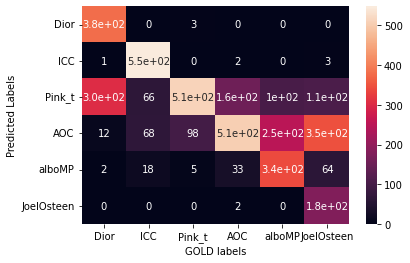

ACCURACY:  0.5991253644314869
F1 Score:  0.6044040283376702


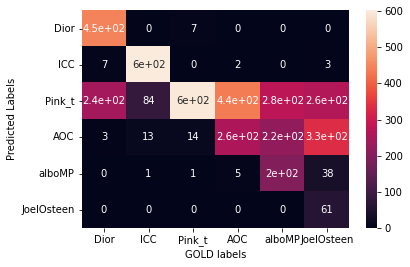

ACCURACY:  0.5252672497570456
F1 Score:  0.5134438941410319


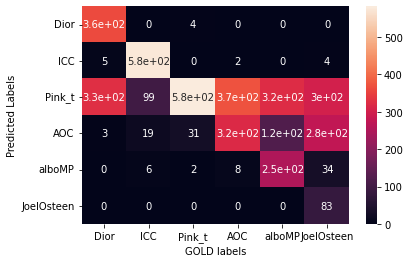

ACCURACY:  0.5279397473275025
F1 Score:  0.5277656312417774


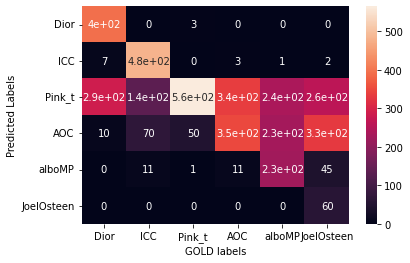

ACCURACY:  0.5051020408163265
F1 Score:  0.5010387265787554


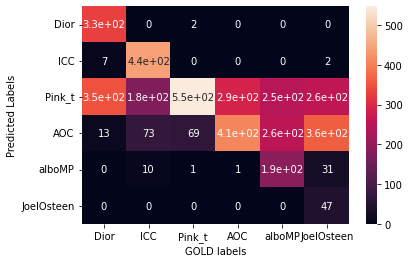

ACCURACY:  0.478134110787172
F1 Score:  0.470445874975209


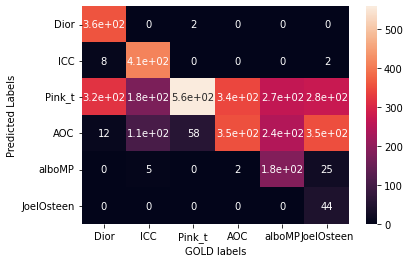

ACCURACY:  0.4655004859086492
F1 Score:  0.4603703312451631


Text(0, 0.5, 'Accuracy')

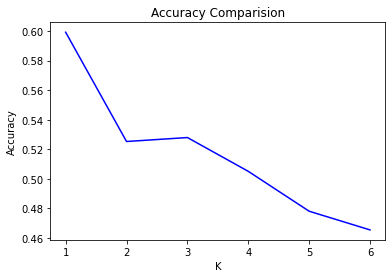

In [ ]:
print("Euclidean Distance")
for i in conf_euc_bow:
    conf_mat = confusion_matrix(i,y_train_bow.astype(int))
    hmap_labels = list(range(conf_mat.shape[0]))
    s = sns.heatmap(conf_mat,xticklabels=authors,yticklabels=authors,annot=True)
    s.set(xlabel="GOLD labels",ylabel="Predicted Labels")
    plt.show()
    f1 = classification_report(i,y_train_bow,labels=[0,1,2,3,4,5],output_dict=True,zero_division=1)['macro avg']['f1-score']
    print("ACCURACY: ",accuracy_score(i,y_train_bow))
    print("F1 Score: ", f1)
xticks = list(range(1,7))
plt.plot(xticks,e_man_bow,color='blue')
plt.title('Accuracy Comparision')
plt.xticks(xticks)
plt.xlabel('K')
plt.ylabel('Accuracy')

In [ ]:
#Using the best value of k perform prediction on the test data, for this instance the highest accuracy was at k = 2

KNN_euclidean = KNeighborsClassifier(n_neighbors=1,p=2)
KNN_euclidean.fit(X_train_bow,y_train_bow)
euclidean_predictions = KNN_euclidean.predict(X_test_bow)

Euclidean Distance


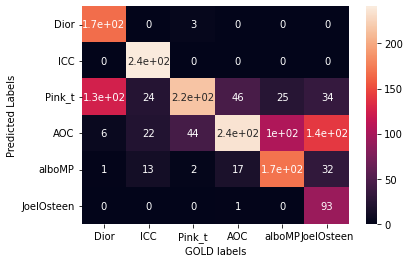

ACCURACY:  0.6366213151927438
Precision:  0.6400538131998346
F1 Score:  0.6417773342213589
Recall:  0.7634134558408904


In [ ]:
#Displaying the confusion matrix, f1 score, accuracy and macro average on the test datat

print("Euclidean Distance")
conf_mat = confusion_matrix(euclidean_predictions,y_test_bow.astype(int))
hmap_labels = list(range(conf_mat.shape[0]))
s = sns.heatmap(conf_mat,xticklabels=authors,yticklabels=authors,annot=True)
s.set(xlabel="GOLD labels",ylabel="Predicted Labels")
plt.show()
t= classification_report(euclidean_predictions,y_test_bow,labels=[0,1,2,3,4,5],output_dict=True,zero_division=1)['macro avg']
precision, recall , f1,= t['precision'] , t['recall'] , t['f1-score']
print("ACCURACY: ",accuracy_score(euclidean_predictions,y_test_bow))
print("Precision: ", precision)
print("F1 Score: ", f1)
print("Recall: ", recall)

##EMBEDDINGS KNN

In [ ]:
e_man=[]
conf_euc=[]
# just like for bag of words perform k fold cross val on each value of k from 1-6
for k in range(1,7):
    KNN = KNeighborsClassifier(n_neighbors=k,p=2)
    cross_val_score(KNN,X_train_embedding,y_train_embedding,cv=5,scoring='accuracy')
    e_man.append(statistics.mean(cross_val_score(KNN,X_train_embedding,y_train_embedding,cv=5,scoring='accuracy')))
    conf_euc.append(cross_val_predict(KNN,X_train_embedding,y_train_embedding,cv=5))


Euclidean Distance


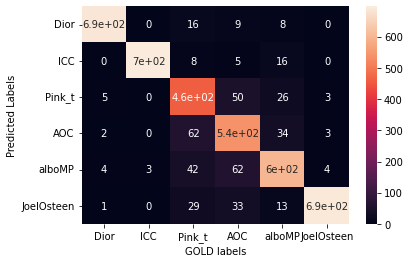

ACCURACY:  0.8935860058309038
F1 Score:  0.8894191243433344


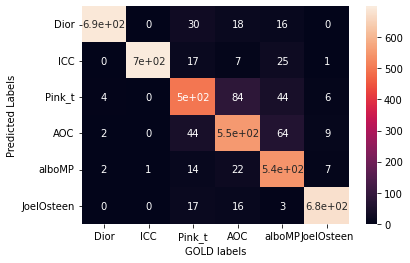

ACCURACY:  0.8899416909620991
F1 Score:  0.8864413079784511


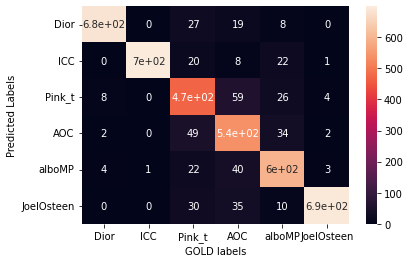

ACCURACY:  0.8945578231292517
F1 Score:  0.8901406449399832


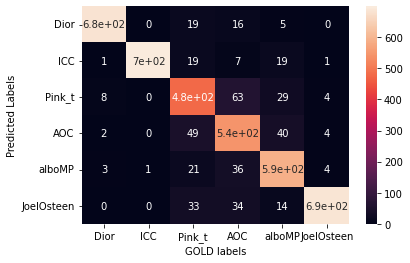

ACCURACY:  0.8950437317784257
F1 Score:  0.8910448541630309


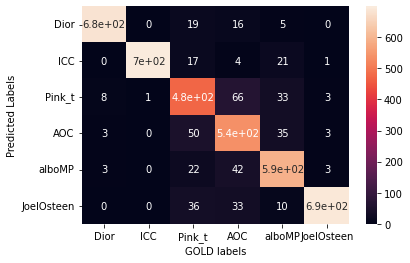

ACCURACY:  0.8945578231292517
F1 Score:  0.8903382164091972


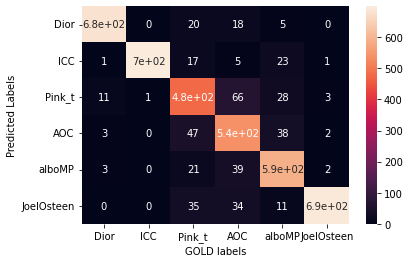

ACCURACY:  0.8945578231292517
F1 Score:  0.890437791847527


Text(0, 0.5, 'Accuracy')

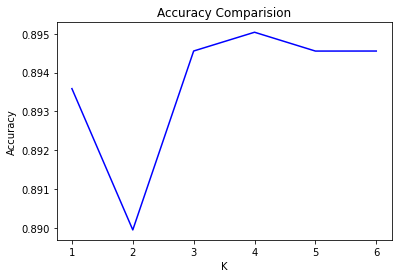

In [ ]:
'''
Display all the confusion matrix and classification report figures for each value of k
'''

print("Euclidean Distance")
for i in conf_euc:
    conf_mat = confusion_matrix(i,y_train_embedding.astype(int))
    s = sns.heatmap(conf_mat,xticklabels=authors,yticklabels=authors,annot=True)
    s.set(xlabel="GOLD labels",ylabel="Predicted Labels")
    plt.show()
    f1 = classification_report(i,y_train_embedding,labels=[0,1,2,3,4,5],output_dict=True,zero_division=1)['macro avg']['f1-score']
    print("ACCURACY: ",accuracy_score(i,y_train_embedding))
    print("F1 Score: ", f1)
xticks = list(range(1,7))
plt.plot(xticks,e_man,color='blue')
plt.title('Accuracy Comparision')
plt.xlabel('K')
plt.ylabel('Accuracy')


In [ ]:
# Make predictions on the best value of k which is 4 for this instance

KNN_euclidean = KNeighborsClassifier(n_neighbors=4,p=2)
KNN_euclidean.fit(X_train_embedding,y_train_embedding)
euclidean_predictions = KNN_euclidean.predict(X_test_embedding)

Euclidean Distance


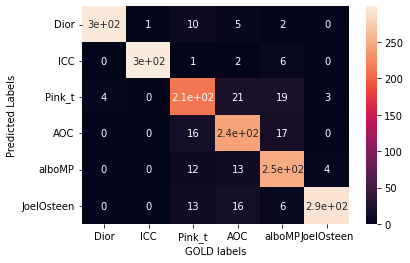

ACCURACY:  0.9030612244897959
Precision:  0.9010915841063504
F1 Score:  0.8998510875389482
Recall:  0.9003493446697656


In [ ]:
# Report accuracy and F1 score of the test data

print("Euclidean Distance")
conf_mat = confusion_matrix(euclidean_predictions,y_test_embedding.astype(int))
hmap_labels = list(range(conf_mat.shape[0]))
s = sns.heatmap(conf_mat,xticklabels=authors,yticklabels=authors,annot=True)
s.set(xlabel="GOLD labels",ylabel="Predicted Labels")
plt.show()
t= classification_report(euclidean_predictions,y_test_embedding,labels=[0,1,2,3,4,5],output_dict=True,zero_division=1)['macro avg']
precision, recall , f1,= t['precision'] , t['recall'] , t['f1-score']
print("ACCURACY: ",accuracy_score(euclidean_predictions,y_test_embedding))
print("Precision: ", precision)
print("F1 Score: ", f1)
print("Recall: ", recall)


##Neural Network Bag of Words

In [ ]:
# Define the neural network for Bag of words classification, it has 3 hidden layers with 80 , 64 and 32 neurons respectively, the optimizer is adam
# Iterations to reach minimum are 300 and the batch size for mini batch gradient decent is 100 and a learning rate of 0.0001
# A higher learning rate was giving worst result so reducing the learning rate and increasing the iteration improves our result

clf = MLPClassifier(solver = "adam", batch_size=100,learning_rate_init = 0.0001,  hidden_layer_sizes = (80,64,32,), max_iter=300 , random_state=5)


In [ ]:
# Performing 5 fold cross validation
cv_results = cross_validate(clf, X_train_bow, y_train_bow, cv=5, return_train_score=False)

Text(0, 0.5, 'Accuracy')

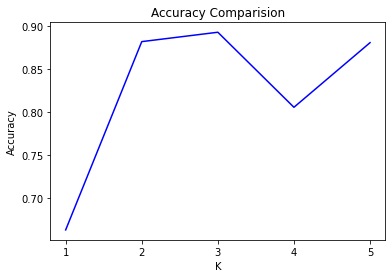

In [ ]:
#Display accuracy at each cross fold
xticks = list(range(1,6))
plt.plot(xticks,cv_results['test_score'],color='blue')
plt.title('Accuracy Comparision')
plt.xticks(xticks)
plt.xlabel('K')
plt.ylabel('Accuracy')

In [ ]:
clf = MLPClassifier(solver = "adam", batch_size=100,learning_rate_init = 0.0001,  hidden_layer_sizes = (80,64,32,), max_iter=300 , random_state=5)

In [ ]:
clf.fit(X_train_bow,y_train_bow)

/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(batch_size=100, hidden_layer_sizes=(80, 64, 32),
              learning_rate_init=0.0001, max_iter=300, random_state=5)

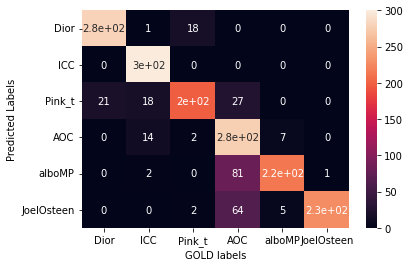

ACCURACY:  0.8509070294784581
Precision:  0.8488900457850418
F1 Score:  0.8531101760630978
Recall:  0.881025615672813


In [ ]:
#Reporting result on the test data of bag of words
pred = clf.predict(X_test_bow)
conf_sk = confusion_matrix(y_test_bow,pred)
s=sns.heatmap(conf_sk, annot=True,xticklabels=authors, yticklabels=authors)
s.set(xlabel="GOLD labels",ylabel="Predicted Labels")
plt.show()
t= classification_report(pred,y_test_bow,labels=[0,1,2,3,4,5],output_dict=True,zero_division=1)['macro avg']
precision, recall , f1,= t['precision'] , t['recall'] , t['f1-score']
print("ACCURACY: ",accuracy_score(pred,y_test_bow))
print("Precision: ", precision)
print("F1 Score: ", f1)
print("Recall: ", recall)

##Neural Network Embeddings





In [ ]:
# Define the neural network for Bag of words classification, it has 3 hidden layers with 80 , 64 and 32 neurons respectively, the optimizer is adam
# Iterations to reach minimum are 300 and the batch size for mini batch gradient decent is 100
# using the same parameters for comparitive results between embeddings and bag of words

clf = MLPClassifier(solver = "adam", batch_size=100,learning_rate_init = 0.0001,  hidden_layer_sizes = (80,64,32,), max_iter=300 , random_state=5)

In [ ]:
# Performing 5 fold cross validation for embeddings data

cv_results = cross_validate(clf, X_train_embedding, y_train_embedding, cv=5, return_train_score=False)
clf.fit(X_train_embedding,y_train_embedding)

MLPClassifier(batch_size=100, hidden_layer_sizes=(80, 64, 32),
              learning_rate_init=0.0001, max_iter=300, random_state=5)

Text(0, 0.5, 'Accuracy')

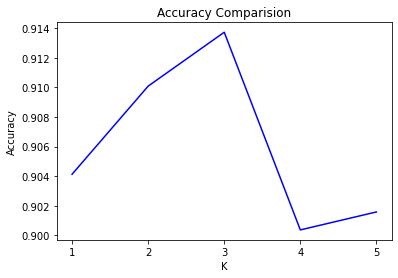

In [ ]:
#Reporting result on the test data of embedding

xticks = list(range(1,6))
plt.plot(xticks,cv_results['test_score'],color='blue')
plt.title('Accuracy Comparision')
plt.xticks(xticks)
plt.xlabel('K')
plt.ylabel('Accuracy')

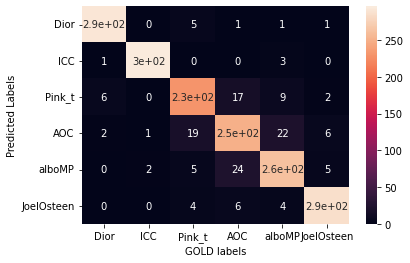

In [ ]:
#Making predictions on the test data to display the confusion matrix
pred = clf.predict(X_test_embedding)
conf_sk = confusion_matrix(y_test_embedding,pred)
s=sns.heatmap(conf_sk, annot=True,xticklabels=authors, yticklabels=authors)
s.set(xlabel="GOLD labels",ylabel="Predicted Labels")
plt.show()

In [ ]:
#Making predictions on the test data to report accuracy, precision, recall and f1 score

precision, recall , f1,_ = classification_report(pred,y_test_embedding,labels=[0,1,2,3,4,5],output_dict=True,zero_division=1)['macro avg']
print("ACCURACY: ",accuracy_score(pred,y_test_embedding))
print("Precision: ", precision)
print("F1 Score: ", f1)
print("Recall: ", recall)

ACCURACY:  0.9172335600907029
Precision:  precision
F1 Score:  f1-score
Recall:  recall


##Random Forest (Bag of Words)



In [ ]:
# Using Random forst as the ensemble method with 50 estimators on bag of words

clf = RandomForestClassifier(n_estimators=50)
clf.fit(X_train_bow, y_train_bow)

RandomForestClassifier(n_estimators=50)

In [ ]:
#making prediction on test data
pred = clf.predict(X_test_bow)

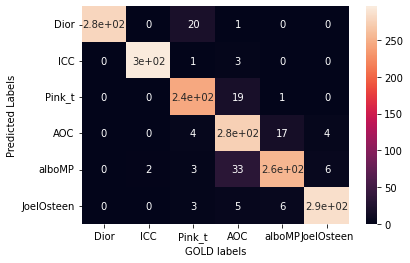

In [ ]:
# Reporting results for test data of bag of words with random forest
conf_sk = confusion_matrix(y_test_bow,pred)
s=sns.heatmap(conf_sk, annot=True,xticklabels=authors, yticklabels=authors)
s.set(xlabel="GOLD labels",ylabel="Predicted Labels")
plt.show()

In [ ]:
t = classification_report(pred,y_test_bow,labels=[0,1,2,3,4,5],output_dict=True,zero_division=1)['macro avg']
precision, recall , f1,= t['precision'] , t['recall'] , t['f1-score']
print("ACCURACY: ",accuracy_score(pred,y_test_bow))
print("Precision: ", precision)
print("F1 Score: ", f1)
print("Recall: ", recall)

ACCURACY:  0.927437641723356
Precision:  0.9273396296530012
F1 Score:  0.9277152689227699
Recall:  0.9299361403027616


##Random Forest (Embeddings)



In [ ]:
# Using Random forst as the ensemble method with 50 estimators on embedding

clf = RandomForestClassifier(n_estimators=50)
clf.fit(X_train_embedding, y_train_embedding)

RandomForestClassifier(n_estimators=50)

In [ ]:
pred = clf.predict(X_test_embedding)

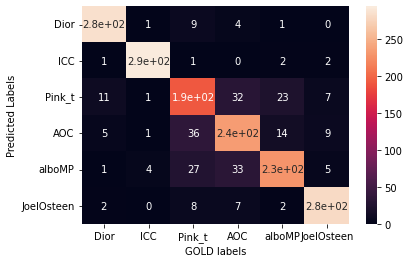

In [ ]:
conf_sk = confusion_matrix(y_test_embedding,pred)
s=sns.heatmap(conf_sk, annot=True,xticklabels=authors, yticklabels=authors)
s.set(xlabel="GOLD labels",ylabel="Predicted Labels")
plt.show()

In [ ]:
# Reporting results for test data of embedding with random forest

t = classification_report(pred,y_test_embedding,labels=[0,1,2,3,4,5],output_dict=True,zero_division=1)['macro avg']
precision, recall , f1,= t['precision'] , t['recall'] , t['f1-score']
print("ACCURACY: ",accuracy_score(pred,y_test_embedding))
print("Precision: ", precision)
print("F1 Score: ", f1)
print("Recall: ", recall)

ACCURACY:  0.858843537414966
Precision:  0.8561068341010917
F1 Score:  0.8558467776843913
Recall:  0.8563939771669351
